# **Описание проекта**
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.


Критерии, которые важны заказчику:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.

# **Инструкция по выполнению проекта**
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.


# **Основные шаги:**
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

## **Примечания:**
 - Для оценки качества моделей применяйте метрику RMSE.
 - Значение метрики RMSE должно быть меньше 2500.
 - Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
 - Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
 - Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

## **Описание данных**
Данные находятся в файле /datasets/autos.csv. Скачать датасет.

**Признаки**
 - `DateCrawled` — дата скачивания анкеты из базы
 - `VehicleType` — тип автомобильного кузова
 - `RegistrationYear` — год регистрации автомобиля
 - `Gearbox` — тип коробки передач
 - `Power` — мощность (л. с.)
 - `Model` — модель автомобиля
 - `Kilometer` — пробег (км)
 - `RegistrationMonth` — месяц регистрации автомобиля
 - `FuelType` — тип топлива
 - `Brand` — марка автомобиля
 - `Repaired` — была машина в ремонте или нет
 - `DateCreated` — дата создания анкеты
 - `NumberOfPictures` — количество фотографий автомобиля
 - `PostalCode` — почтовый индекс владельца анкеты (пользователя)
 - `LastSeen` — дата последней активности пользователя

**Целевой признак**

 - `Price` — цена (евро)

In [1]:
!pip install lightgbm

In [2]:
 !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error


from catboost import CatBoostRegressor, Pool, metrics

import lightgbm as lgb

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **1. Загрузите данные**

In [4]:
url = 'https://drive.google.com/file/d/1gcZlmq0K9l0yhBDGLyZCBFVEo1v2bBXJ/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
data = df.copy()
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


# **2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

,0
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Столбцы `DateCrawled(дата скачивания анкеты из базы)`, `DateCreated(дата создания анкеты)`, `LastSeen(дата последней активности пользователя)`, `PostalCode(почтовый индекс владельца анкеты)` по моему мнению никак логически не связаны с целевой переменной, поэтому удалим их датасета.

Столбец `NumberOfPictures` состоит из одних нулей и не несет никакой информационной составляющей, поэтому также удалим его из датасета.

In [8]:
columns_for_deleting = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode','NumberOfPictures']
df = df.drop(columns_for_deleting, axis=1)

In [9]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Проанализируем категориальные столбцы `'VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'Repaired'` на предмет дубликатов записанных разным регистром или разным языком.

In [10]:
categoric = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'Repaired']
for column in categoric:
  print('*'*100)
  print(column)
  print(df[column].unique())
  print('*'*100)

****************************************************************************************************
VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
****************************************************************************************************
****************************************************************************************************
Gearbox
['manual' 'auto' nan]
****************************************************************************************************
****************************************************************************************************
Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc

Дубликатов записанных разным регистром или языком не обнаружено. Есть пропуски, по видимому при заполнении анкеты пользователи, если не знали какой-то параметр просто оставляли эту графу пустой. Заполним все пропущенные значения на `not specified (не указано)`.

In [11]:
for column in categoric:
  df[column]= df[column].fillna('not specified')

In [12]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,not specified,1993,manual,0,golf,150000,0,petrol,volkswagen,not specified
1,18300,coupe,2011,manual,190,not specified,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not specified
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Построим матрицу корреляции для количественных признаков.

In [13]:
numeric = ['Price','RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
cm = sns.light_palette("green", as_cmap=True)
df[numeric].corr().style.background_gradient(cmap=cm)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.026916,0.158872,-0.333199,0.110581
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619
Power,0.158872,-0.000828,1.000000,0.024002,0.043380
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000


Наибольший положительный коэффициент корреляции имеет пара признаков `Price` - `Power`, что логично более мощные автомобили должны стоить дороже.
Наибольший по модулю отрицательный коэффициент корреляции имеет пара признаков `Price` - `Kilometer`, что тоже поддается логике, чем больше пробег машины тем она стоит дешевле.

 Построим графики зависимости цены от среднего пробега автомобиля и цены от средней мощности. Для этого округлим цену до 1000 евро сгруппируем данные по цене и вычислим средний пробег и среднюю мощность авто соответственно.

In [14]:
df['price_range'] = round(df['Price']/1000)*1000
df.sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,price_range
222959,1500,small,1999,auto,0,fortwo,125000,1,petrol,smart,no,2000.0
13433,15000,wagon,2012,manual,136,c_klasse,125000,5,gasoline,mercedes_benz,no,15000.0
248989,1333,small,1998,manual,82,a_klasse,150000,6,petrol,mercedes_benz,no,1000.0
71556,1499,small,2001,manual,58,twingo,150000,11,petrol,renault,no,1000.0
58632,1300,not specified,2018,manual,60,not specified,150000,3,petrol,peugeot,no,1000.0
215759,1200,not specified,2016,manual,0,focus,150000,10,petrol,ford,no,1000.0
214107,4490,convertible,1998,manual,101,golf,150000,6,petrol,volkswagen,no,4000.0
36965,0,sedan,1998,manual,90,escort,150000,12,not specified,ford,not specified,0.0
219846,3650,small,2007,manual,60,corsa,125000,9,petrol,opel,no,4000.0
53190,10800,convertible,2004,auto,218,clk,150000,7,lpg,mercedes_benz,not specified,11000.0


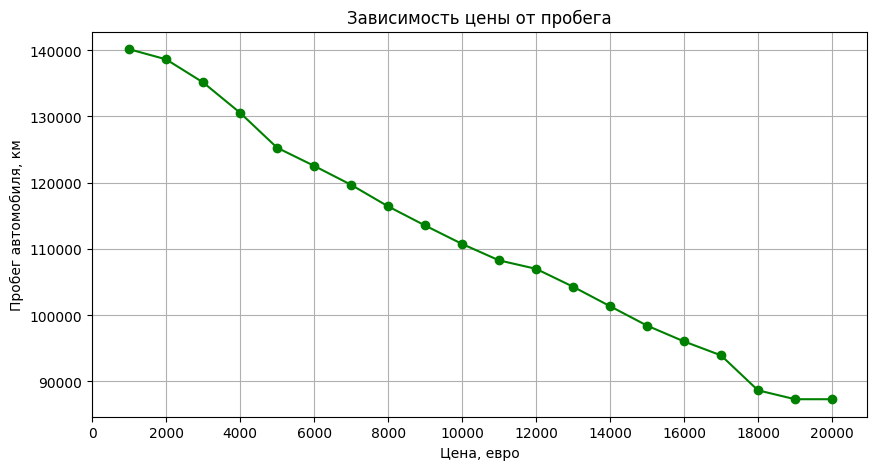

In [15]:
(df[df['price_range']!=0].groupby('price_range')
                         .agg({'Kilometer':'mean'})
                         .plot(style='o-',
                               figsize=(10,5),
                               grid=True,
                               legend=False,
                               color='g'))
plt.xticks(range(0,22000,2000))
plt.xlabel('Цена, евро')
plt.ylabel('Пробег автомобиля, км')
plt.title('Зависимость цены от пробега')
plt.show()

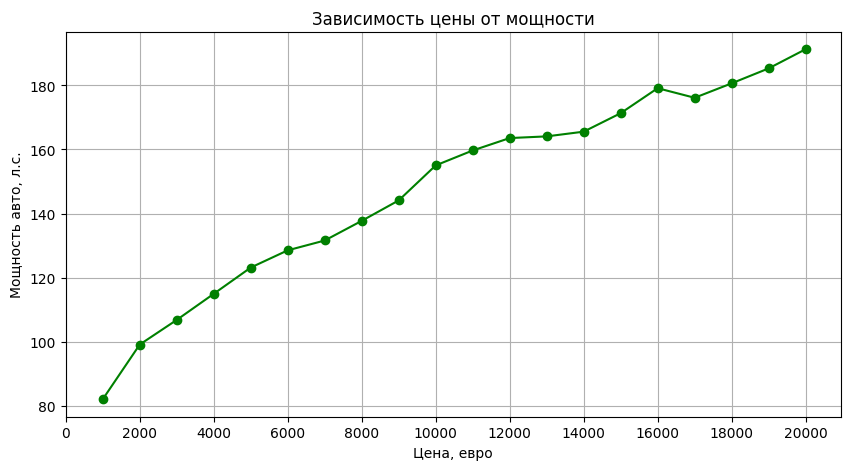

In [16]:
(df[df['price_range']!=0].groupby('price_range')
                         .agg({'Power':'mean'})
                         .plot(style='o-',
                               figsize=(10,5),
                               grid=True,
                               legend=False,
                               color='g'))
plt.xticks(range(0,22000,2000))
plt.xlabel('Цена, евро')
plt.ylabel('Мощность авто, л.с.')
plt.title('Зависимость цены от мощности')
plt.show()

In [17]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,price_range
0,480,not specified,1993,manual,0,golf,150000,0,petrol,volkswagen,not specified,0.0
1,18300,coupe,2011,manual,190,not specified,125000,5,gasoline,audi,yes,18000.0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not specified,10000.0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2000.0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,4000.0


Определим выбросы в признаках `Price`, `RegistrationYear`, `Power`, `Kilometer` с помощью инструмента `boxplot`

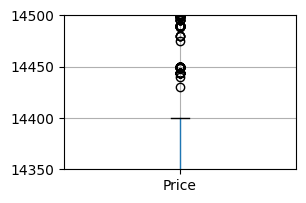

In [18]:
df.boxplot('Price', figsize = (3,2))
plt.ylim(14350, 14500)
plt.show()

In [19]:
len(df[df['Price']==0])*100/len(df)

3.0397692800442475

In [20]:
len(df[df['Price']>14430])*100/len(df)

5.355434589368709

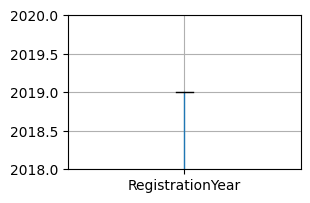

In [21]:
df.boxplot('RegistrationYear', figsize = (3,2))
plt.ylim(2018, 2020)
plt.show()

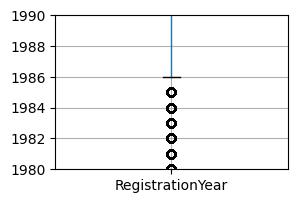

In [22]:
df.boxplot('RegistrationYear', figsize = (3,2))
plt.ylim(1980, 1990)
plt.show()

In [23]:
len(df[(df['RegistrationYear']>2019) | (df['RegistrationYear']<1986)])*100/len(df)

1.7803476037689527

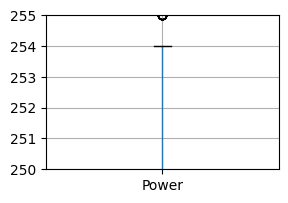

In [24]:
df.boxplot('Power', figsize = (3,2))
plt.ylim(250, 255)
plt.show()

In [25]:
len(df[df['Power']>=255])*100/len(df)

2.071287273999701

In [26]:
len(df[df['Power']==0])*100/len(df)

11.351162206626427

In [27]:
len(df[df['RegistrationMonth']==0 ])*100/len(df)

10.540425375808832

Среди месяцев регистрации авто присутсвуют нулевые и их доля довольно высока, скорее всего продавцы точно не знали эту информации и просто указывали ноль в этой графе, поэтому оставим эти значения в датасете.

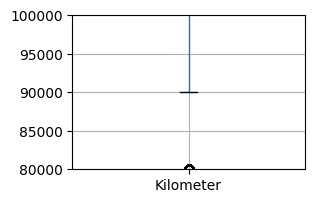

In [28]:
df.boxplot('Kilometer', figsize=(3,2))
plt.ylim(80000, 100000)
plt.show()

In [29]:
len(df[df['Kilometer']<=20000])*100/len(df)

3.271730879394078

In [30]:
df_outlayers_index = df[(df['Price']==0) | (df['Price']>14340) |
                         (df['RegistrationYear']>2019) | (df['RegistrationYear']<1986) |
                         (df['Power']>=255) |
                         (df['Kilometer']<=80000)].index

In [31]:
len(df_outlayers_index)/len(df)

0.22612869635888014

В итоге пришлось удалить почти 23% данных, которые являются выбросами. Это должно помочь увеличить обобщащую способность моделей предсказывать цену.

In [32]:
df_with_outlayers = df.copy()
df = df.drop(index=df_outlayers_index)


# **3. Подготовьте выборки для обучения моделей.**

In [33]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
df = df.drop('price_range', axis=1) # удалим вспомогательный столбец 'price_range'

target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
features_valid, target_valid, test_size=0.5, random_state=12345)

print(f'Размер выборки для обучения(train): {features_train.shape} , от общего объема датасета {round(features_train.shape[0]/df.shape[0],2)*100} %')
print(f'Размер выборки для валидации(valid): {features_valid.shape} , от общего объема датасета {round(features_valid.shape[0]/df.shape[0],2)*100} %')
print(f'Размер выборки для тестирования(test): {features_test.shape} , от общего объема датасета {round(features_test.shape[0]/df.shape[0],2)*100} %')



Размер выборки для обучения(train): (164541, 10) , от общего объема датасета 60.0 %
Размер выборки для валидации(valid): (54847, 10) , от общего объема датасета 20.0 %
Размер выборки для тестирования(test): (54848, 10) , от общего объема датасета 20.0 %


# **4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.**

## **4.1 Линейная регрессия**

Для линейной регрессии потребуется обработать категориальные признаки с помощью `OrdinalEncoder` и масштабировать числовые признаки с помощью `StandardScaler`

In [34]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(features_train[categorical])

features_train[categorical] = enc.transform(features_train[categorical])
features_valid[categorical] = enc.transform(features_valid[categorical])
features_test[categorical] = enc.transform(features_test[categorical])

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [35]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
rmse_lr = root_mean_squared_error(target_valid, predictions)
print(f'RMSE линейной регресии на валидационной выборке: {rmse_lr:.2f}')

RMSE линейной регресии на валидационной выборке: 2222.76


Напишем функции для измерения времени обучения и предсказания с помощью специальной команды `%timeit`

In [36]:
def timing_train():

    time_train = %timeit -n1 -r1 -o model.fit(features_train, target_train)
    time_train = round(time_train.average,3)
    return time_train

def timing_predict():
    time_predict = %timeit -n1 -r1 -o model.predict(features_train)
    time_predict = round(time_predict.average,3)
    return time_predict

In [37]:
time_train_lr = timing_train()
print(f'Время обучения линейной регресии {time_train_lr} сек.')

101 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время обучения линейной регресии 0.101 сек.


In [38]:
time_predict_lr = timing_predict()
print(f'Время предсказания линейной регресии {time_predict_lr} сек.')

8.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время предсказания линейной регресии 0.008 сек.


## **4.2 Решающее дерево**

Для решающего дерева обработаем только категориальные признаки.

In [39]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
features_valid, target_valid, test_size=0.5, random_state=12345)


In [40]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(features_train[categorical])

features_train[categorical] = enc.transform(features_train[categorical])
features_valid[categorical] = enc.transform(features_valid[categorical])
features_test[categorical] = enc.transform(features_test[categorical])

Определим наилучшую глубину дерева, которая дает наилучшую метрику RMSE. Так же будем считать разницу в процентах между метрикой на валидационной и обучающей выборке. Если эта разница будет очень большая  - это будет свидетельствовать о переобучении модели решающего дерева.

In [41]:
for depth in range(2,15):
  model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
  model.fit(features_train, target_train)
  predictions = model.predict(features_valid)
  predictions_train = model.predict(features_train)
  rmse_valid = root_mean_squared_error(target_valid, predictions)
  rmse_train = root_mean_squared_error(target_train, predictions_train)
  print(f'depth={depth:>2}, rmse_train = {rmse_train:.4f}, rmse_valid = {rmse_valid:.4f}, diff = {abs(rmse_valid - rmse_train)*100/rmse_train:.2f} %')

depth= 2, rmse_train = 2276.8206, rmse_valid = 2275.1575, diff = 0.07 %
depth= 3, rmse_train = 2119.6495, rmse_valid = 2123.5511, diff = 0.18 %
depth= 4, rmse_train = 1949.2423, rmse_valid = 1955.7703, diff = 0.33 %
depth= 5, rmse_train = 1825.6365, rmse_valid = 1837.4733, diff = 0.65 %
depth= 6, rmse_train = 1723.0591, rmse_valid = 1744.4395, diff = 1.24 %
depth= 7, rmse_train = 1651.7780, rmse_valid = 1672.8184, diff = 1.27 %
depth= 8, rmse_train = 1586.9967, rmse_valid = 1615.0768, diff = 1.77 %
depth= 9, rmse_train = 1517.8763, rmse_valid = 1568.2450, diff = 3.32 %
depth=10, rmse_train = 1448.0614, rmse_valid = 1526.4827, diff = 5.42 %
depth=11, rmse_train = 1378.5040, rmse_valid = 1490.4314, diff = 8.12 %
depth=12, rmse_train = 1301.8779, rmse_valid = 1475.2528, diff = 13.32 %
depth=13, rmse_train = 1220.5295, rmse_valid = 1468.1609, diff = 20.29 %
depth=14, rmse_train = 1137.2982, rmse_valid = 1466.8285, diff = 28.97 %


Наилучший результат показало дерево с максимальной глубиной равной 9, разница между метриками на валидационной и обучающей выборками 3.32%

In [42]:
model = DecisionTreeRegressor(max_depth=9, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
rmse_dt = root_mean_squared_error(target_valid, predictions)
print(f'RMSE на валидационной выбоке решающего дерева: {rmse_dt:.2f}')

RMSE на валидационной выбоке решающего дерева: 1568.24


In [43]:
time_train_dt = timing_train()
print(f'Время обучения решающего дерева: {time_train_dt} сек')

385 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время обучения решающего дерева: 0.385 сек


In [44]:
time_predict_dt = timing_predict()
print(f'Время предсказания решающего дерева: {time_predict_dt} сек')

21.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время предсказания решающего дерева: 0.022 сек


## **4.3 Случайный лес**

Для обучения модели случайного леса будем использовать те же самые обработанные данные для обучения и дерево с максимальной глубиной 9.

In [45]:
for n_est in range(10,150,10):
  model = RandomForestRegressor(n_estimators=n_est, max_depth=9, random_state=12345)
  model.fit(features_train, target_train)
  predictions = model.predict(features_valid)
  predictions_train = model.predict(features_train)
  rmse_valid = root_mean_squared_error(target_valid, predictions)
  rmse_train = root_mean_squared_error(target_train, predictions_train)
  print(f'n_est={n_est:>3}, rmse_train = {rmse_train:.4f}, rmse_valid = {rmse_valid:.4f}, diff = {abs(rmse_valid - rmse_train)*100/rmse_train:.2f} %')

n_est= 10, rmse_train = 1469.5963, rmse_valid = 1518.3495, diff = 3.32 %
n_est= 20, rmse_train = 1467.1917, rmse_valid = 1516.2614, diff = 3.34 %
n_est= 30, rmse_train = 1464.6991, rmse_valid = 1512.2455, diff = 3.25 %
n_est= 40, rmse_train = 1463.8942, rmse_valid = 1511.2080, diff = 3.23 %
n_est= 50, rmse_train = 1462.1088, rmse_valid = 1509.2229, diff = 3.22 %
n_est= 60, rmse_train = 1461.6129, rmse_valid = 1508.8403, diff = 3.23 %
n_est= 70, rmse_train = 1461.4066, rmse_valid = 1508.2363, diff = 3.20 %
n_est= 80, rmse_train = 1461.8682, rmse_valid = 1508.6982, diff = 3.20 %
n_est= 90, rmse_train = 1461.5953, rmse_valid = 1508.2565, diff = 3.19 %
n_est=100, rmse_train = 1461.4823, rmse_valid = 1508.0524, diff = 3.19 %
n_est=110, rmse_train = 1461.1782, rmse_valid = 1507.7865, diff = 3.19 %
n_est=120, rmse_train = 1461.1998, rmse_valid = 1507.8875, diff = 3.20 %
n_est=130, rmse_train = 1461.0924, rmse_valid = 1507.8020, diff = 3.20 %
n_est=140, rmse_train = 1461.1212, rmse_valid = 150

Наилучший параметр n_estimartors=50. После его увеличения метрика RMSE увеличивается незначительно.

In [46]:
model = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
predictions_train = model.predict(features_train)
rmse_rf = root_mean_squared_error(target_valid, predictions)
print(f'RMSE случайного леса : {rmse_rf:.2f}')

RMSE случайного леса : 1509.22


In [47]:
time_train_rf = timing_train()
print(f'Время обучения случайного леса {time_train_rf} сек')

13.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время обучения случайного леса 13.364 сек


In [48]:
time_predict_rf = timing_predict()
print(f'Время предсказания случайного леса {time_predict_rf} сек')

681 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время предсказания случайного леса 0.681 сек


## **4.4 CatBoost**

Catboost способен работать с категориальными признами нужно только выделить их и обозначить для модели.

In [49]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
features_valid, target_valid, test_size=0.5, random_state=12345)

In [50]:
train_pool = Pool(features_train, label=target_train,
                  cat_features=categorical)
test_pool = Pool(features_valid, label=target_valid,
                  cat_features=categorical)

#cb_rmse = CatBoostRegressor(loss_function='RMSE', n_estimators=1000, silent=True)
cb_rmse = CatBoostRegressor(loss_function='RMSE', iterations=2000, learning_rate = 0.3, depth = 4, verbose=100)
cb_rmse.fit(train_pool, eval_set=test_pool, plot=False)

0:	learn: 2633.4620140	test: 2627.2256937	best: 2627.2256937 (0)	total: 210ms	remaining: 6m 59s
100:	learn: 1327.3805945	test: 1343.6246622	best: 1343.6246622 (100)	total: 12.7s	remaining: 3m 58s
200:	learn: 1291.3452894	test: 1312.1036819	best: 1312.0953394 (199)	total: 25s	remaining: 3m 43s
300:	learn: 1273.1318433	test: 1297.5987915	best: 1297.5987915 (300)	total: 39.2s	remaining: 3m 41s
400:	learn: 1259.8056564	test: 1288.6279381	best: 1288.6279381 (400)	total: 50.9s	remaining: 3m 23s
500:	learn: 1249.0820423	test: 1282.1612848	best: 1282.1250685 (496)	total: 1m 3s	remaining: 3m 9s
600:	learn: 1240.8962106	test: 1277.4071097	best: 1277.4071097 (600)	total: 1m 14s	remaining: 2m 52s
700:	learn: 1233.4742788	test: 1273.1123848	best: 1273.1123848 (700)	total: 1m 26s	remaining: 2m 41s
800:	learn: 1227.1337542	test: 1270.1774510	best: 1270.1774510 (800)	total: 1m 39s	remaining: 2m 29s
900:	learn: 1222.1717644	test: 1268.3246784	best: 1268.2795516 (894)	total: 1m 52s	remaining: 2m 17s
100

In [51]:
cb_rmse = CatBoostRegressor(loss_function='RMSE', iterations=300, learning_rate = 0.3, depth = 4)
cb_rmse.fit(train_pool, eval_set=test_pool, verbose=300)

0:	learn: 2633.4620140	test: 2627.2256937	best: 2627.2256937 (0)	total: 159ms	remaining: 47.6s
299:	learn: 1273.3670271	test: 1297.9165822	best: 1297.9165822 (299)	total: 37.2s	remaining: 0us

bestTest = 1297.916582
bestIteration = 299



In [52]:
predictions = cb_rmse.predict(features_valid)
rmse_catboost = root_mean_squared_error(predictions, target_valid)
print(f'RMSE модели catboost {rmse_catboost}')

RMSE модели catboost 1297.9165822442126


In [53]:
time_train_catboost = %timeit -n1 -r1 -o cb_rmse.fit(train_pool, eval_set=test_pool, verbose=300)
time_train_catboost = round(time_train_catboost.average,3)
print(f'Время обучения модели Catboost: {time_train_catboost} сек.')

0:	learn: 2633.4620140	test: 2627.2256937	best: 2627.2256937 (0)	total: 153ms	remaining: 45.9s
299:	learn: 1273.3670271	test: 1297.9165822	best: 1297.9165822 (299)	total: 35.4s	remaining: 0us

bestTest = 1297.916582
bestIteration = 299

35.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время обучения модели Catboost: 35.582 сек.


In [54]:
time_predict_catboost = %timeit -n1 -r1 -o cb_rmse.predict(features_valid)
time_predict_catboost = round(time_predict_catboost.average,3)
print(f'Время предсказания модели Catboost: {time_predict_catboost} сек.')

163 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время предсказания модели Catboost: 0.163 сек.


In [55]:
np.array(cb_rmse.get_feature_importance(prettified=True))

array([['RegistrationYear', 40.947883775169146],
       ['Power', 20.132773455461955],
       ['VehicleType', 12.857699800836716],
       ['Brand', 9.72829758020388],
       ['Model', 5.303302698998362],
       ['Kilometer', 4.436936582003589],
       ['Repaired', 3.413172656739094],
       ['FuelType', 2.4150853615701795],
       ['Gearbox', 0.6187421894864676],
       ['RegistrationMonth', 0.14610589953062464]], dtype=object)

Можно сделать вывод, что признаки `Gearbox` и `RegistrationMonth` обладают малой значимостью для модели. В теории при удалении этих признаков из обучающего датасета ключевая метрика может немного ухудшиться, но модель должна быстрее обучаться и предсказывать.

## **4.5 LightGBM**

In [56]:
target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
features_valid, target_valid, test_size=0.5, random_state=12345)


enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(features_train[categorical])

features_train[categorical] = enc.transform(features_train[categorical])
features_valid[categorical] = enc.transform(features_valid[categorical])
features_test[categorical] = enc.transform(features_test[categorical])


scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [57]:
lgbm = lgb.LGBMRegressor(objective='regression', n_estimators=5000, learning_rate=0.05,\
                         early_stopping_round=10)
lgbm.fit(features_train, target_train, eval_set=[(features_valid, target_valid)], eval_metric="rmse")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 164541, number of used features: 10
[LightGBM] [Info] Start training from score 3384.579497
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2027]	valid_0's rmse: 1228.94	valid_0's l2: 1.51029e+06


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(early_stopping_round=10, learning_rate=0.05, n_estimators=5000,
              objective='regression')

In [58]:
predictions = lgbm.predict(features_valid)
rmse_lgbm = root_mean_squared_error(target_valid, predictions)
print(f'RMSE модели LightGBM: {rmse_lgbm}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RMSE модели LightGBM: 1228.9382656264472


In [59]:
lgbm = lgb.LGBMRegressor(objective='regression', n_estimators=5000, learning_rate=0.05,\
                         early_stopping_round=10)
time_train_lgbm = %timeit -n1 -r1 -o lgbm.fit(features_train, target_train, \
                                                   eval_set=[(features_valid, target_valid)], eval_metric="rmse")
time_train_lgbm = round(time_train_lgbm.average,3)
print(f'Время обучения модели LightGBM: {time_train_lgbm:.2f}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 164541, number of used features: 10
[LightGBM] [Info] Start training from score 3384.579497
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2027]	valid_0's rmse: 1228.94	valid_0's l2: 1.51029e+06
20.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время обучения модели LightGBM: 20.84


In [60]:
time_predict_lgbm = %timeit -n1 -r1 -o train_preds = lgbm.predict(features_valid)
time_predict_lgbm = round(time_predict_lgbm.average,3)
print(f'Время предсказания модели LightGBM: {time_predict_lgbm:.2f}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


8.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Время предсказания модели LightGBM: 8.63


# **5.Проанализируйте время обучения, время предсказания и качество моделей.**

Оформим полученные результаты от 5-ти моделей в датафрейм.

In [61]:
columns = ['RMSE', 'Время обучения,сек', 'Время предсказания,сек']
result = pd.DataFrame(columns = columns, data =\
                            [[rmse_lr, time_train_lr, time_predict_lr],
                             [rmse_dt, time_train_dt, time_predict_dt],
                             [rmse_rf, time_train_rf, time_predict_rf],
                             [rmse_catboost, time_train_catboost, time_predict_catboost],
                             [rmse_lgbm, time_train_lgbm, time_predict_lgbm]])
result

,RMSE,"Время обучения,сек","Время предсказания,сек"
0,2222.760088,0.101,0.008
1,1568.244995,0.385,0.022
2,1509.222865,13.364,0.681
3,1297.916582,35.582,0.163
4,1228.938266,20.837,8.634


Дополнительно последней шестой строкой в датафрейме расчитаем средние значения метрики RMSE, времени обучения и предсказания.

In [63]:
average = []
for col in result.columns:
  average.append(result[col].mean())
result.loc[5] = average
result


,RMSE,"Время обучения,сек","Время предсказания,сек"
0,2222.760088,0.1010,0.0080
1,1568.244995,0.3850,0.0220
2,1509.222865,13.3640,0.6810
3,1297.916582,35.5820,0.1630
4,1228.938266,20.8370,8.6340
5,1565.416559,14.0538,1.9016


Для определения лучшей модели для заказчика рассчитаем евклидово расстояние от векторов строк датасета с результатами до вектора средних значений. То расстояние, которое будет не равно нулю и будет при этом наименьшим укажет на модель наиболее подходящую под критерии заказчика.

In [64]:
dist = []
for i in range(6):
  dist.append(distance.euclidean(result.loc[i], result.loc[5]))
result['Евклидово расстояние до среднего'] = dist
result.index = ['Линейная регрессия','Решающее дерево', 'Случайный лес', 'Catboost', 'LightGBM', 'Среднее']
result

,RMSE,"Время обучения,сек","Время предсказания,сек",Евклидово расстояние до среднего
Линейная регрессия,2222.760088,0.1010,0.0080,657.494320
Решающее дерево,1568.244995,0.3850,0.0220,14.084354
Случайный лес,1509.222865,13.3640,0.6810,56.211182
Catboost,1297.916582,35.5820,0.1630,268.370497
LightGBM,1228.938266,20.8370,8.6340,336.613991
Среднее,1565.416559,14.0538,1.9016,0.000000


# **6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.**

Модель случайного леса оказалась наиболее близка с средним значением всех моделей. Проверим ее на тестовой выборке.

In [65]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
features_valid, target_valid, test_size=0.5, random_state=12345)

In [66]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(features_train[categorical])

features_train[categorical] = enc.transform(features_train[categorical])

features_valid[categorical] = enc.transform(features_valid[categorical])

features_test[categorical] = enc.transform(features_test[categorical])

In [67]:
model = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse_test = root_mean_squared_error(target_test, predictions)
print(f'RMSE модели случайного леса: {rmse_test:.2f}')

RMSE модели случайного леса: 1501.10
